In [ ]:
#libraries
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch
from torchvision.models import vgg19, VGG19_Weights
import tensorflow as tf
from tensorflow.keras import layers, Model
from torch.cuda.amp import autocast, GradScaler
from google.colab import drive
import zipfile
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import gc
import random
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter







In [ ]:
#extracting data from zip file

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Wider-Face/train/sharp/CelebA.zip'
extracted_path = '/content/data/CelebA'
os.makedirs(extracted_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Extracted files to: {extracted_path}")


Mounted at /content/drive
Extracted files to: /content/data/CelebA


In [ ]:
import torch
#checking the availablility of cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:


class PairedSRDataset(Dataset):
    def __init__(self, root_dir, lr_folder='blur', hr_folder='sharp', lr_size=64):
        '''
        Args:
            root_dir: Root directory containing 'blur' and 'sharp' subfolders
            lr_folder: Folder with Low-Resolution images
            hr_folder: Folder with High-Resolution images
            lr_size: Size to resize LR images (HR will be resized to 4× of LR)
        '''
        self.lr_size = lr_size
        self.hr_size = lr_size * 4

        # Load and match file paths by basename
        lr_files = sorted(glob(os.path.join(root_dir, lr_folder, '*')))
        hr_files = sorted(glob(os.path.join(root_dir, hr_folder, '*')))
        hr_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in hr_files}

        self.lr_paths = []
        self.hr_paths = []

        for lr_path in lr_files:
            lr_base = os.path.splitext(os.path.basename(lr_path))[0]
            if lr_base in hr_dict:
                self.lr_paths.append(lr_path)
                self.hr_paths.append(hr_dict[lr_base])

        print(f"Found {len(self.lr_paths)} paired images.")

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr_path = self.lr_paths[idx]
        hr_path = self.hr_paths[idx]

        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")

        # --- Apply identical transforms to both images --- #

        # Random horizontal flip
        if random.random() > 0.5:
            lr_img = TF.hflip(lr_img)
            hr_img = TF.hflip(hr_img)

        # Random rotation
        angle = random.uniform(-10, 10)
        lr_img = TF.rotate(lr_img, angle)
        hr_img = TF.rotate(hr_img, angle)

        # Color jitter
        brightness = random.uniform(0.9, 1.1)
        contrast = random.uniform(0.9, 1.1)
        saturation = random.uniform(0.9, 1.1)

        lr_img = TF.adjust_brightness(lr_img, brightness)
        hr_img = TF.adjust_brightness(hr_img, brightness)

        lr_img = TF.adjust_contrast(lr_img, contrast)
        hr_img = TF.adjust_contrast(hr_img, contrast)

        lr_img = TF.adjust_saturation(lr_img, saturation)
        hr_img = TF.adjust_saturation(hr_img, saturation)

        # Resize explicitly to correct sizes (in case original sizes vary)

        lr_img = TF.resize(lr_img, (self.lr_size, self.lr_size), interpolation=Image.BICUBIC)
        hr_img = TF.resize(hr_img, (self.hr_size, self.hr_size), interpolation=Image.BICUBIC)

        # Convert to tensors and normalize [-1, 1]
        lr_tensor = TF.to_tensor(lr_img)
        hr_tensor = TF.to_tensor(hr_img)

        lr_tensor = TF.normalize(lr_tensor, (0.5,) * 3, (0.5,) * 3)
        hr_tensor = TF.normalize(hr_tensor, (0.5,) * 3, (0.5,) * 3)

        return lr_tensor, hr_tensor



# Example: load training set
train_ds = PairedSRDataset('/content/data/CelebA/CelebA/train')

# Create subset of first 5k images
subset_size = min(15000, len(train_ds))
train_subset = Subset(train_ds, indices=range(subset_size))

#Data loader
train_loader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

Found 200000 paired images.


15000


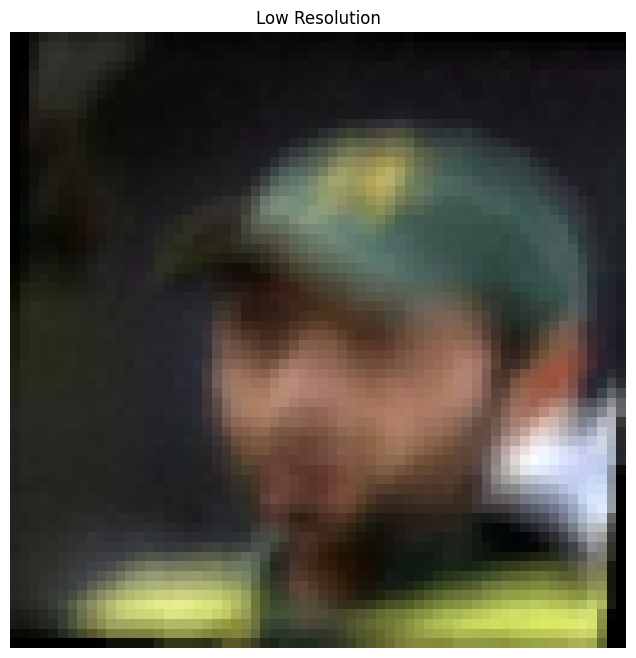

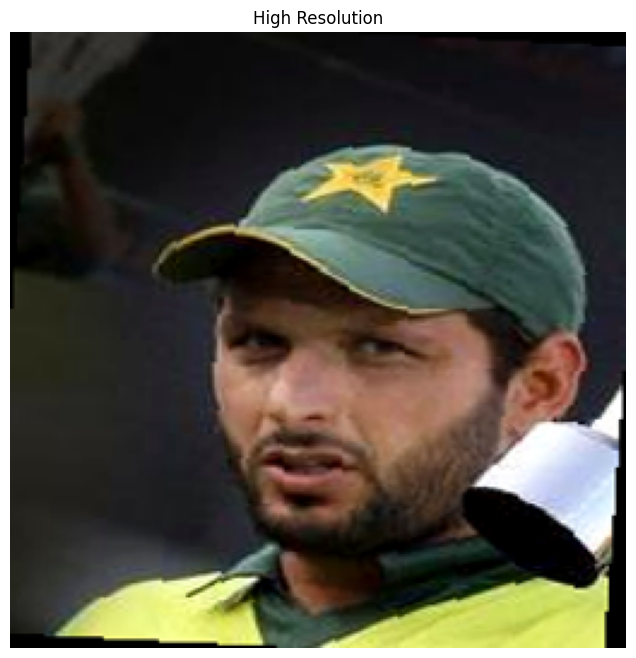

In [ ]:
#printing image as a sample
print(len(train_subset))
#show image

lr, hr = train_subset[0]  # Low-res and high-res tensors

# Convert tensors back to images
lr_img = TF.to_pil_image((lr * 0.5 + 0.5))  # De-normalize
hr_img = TF.to_pil_image((hr * 0.5 + 0.5))  # De-normalize

# Plot the images
plt.figure(figsize=(12, 8))

plt.title("Low Resolution")
plt.imshow(lr_img)
plt.axis("off")
plt.show()
plt.figure(figsize=(12, 8))
plt.title("High Resolution")
plt.imshow(hr_img)
plt.axis("off")

plt.show()


In [ ]:
# Generator network based on Residual-in-Residual Dense Blocks (RRDB)
# This architecture is used for super-resolution (e.g., ESRGAN)
# Structure of the model is described in ReadMe file

# Single Residual Dense Block: combines dense connections with residual scaling
# Genarator tries to Generate the real image, While discriminator act as a judge to
# distinguish between real and fake image

class ResidualDenseBlock(nn.Module):
    def __init__(self, num_feat=64, num_grow_ch=32):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # 1 padding to ensure same output size as input
        # 1 stride, better to get spatial info
        # 3x3 kernel is normal to extract features
        # First convolution: input channels -> growth channels
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        # Subsequent convolutions: input channels grow due to concatenation
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        # Last convolution reduces back to original feature size
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)
        # Non-linearity
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        # First layer
        x1 = self.lrelu(self.conv1(x))
        # Concatenate previous outputs and input, then convolve
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        # Final convolution after dense connections
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Residual scaling (0.2) and skip connection
        return x5 * 0.2 + x



# Residual-in-Residual Dense Block: stacks 3 ResidualDenseBlocks with outer residual

class RRDB(nn.Module):
    def __init__(self, num_feat=64, num_grow_ch=32):
        super().__init__()
        # Stack 3 ResidualDenseBlocks
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        # Sequentially pass through each RDB
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        # Outer residual connection with scaling
        return out * 0.2 + x



# Full RRDBNet: backbone for super-resolution generator

class RRDBNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, num_feat=64, num_block=23, num_grow_ch=32):
        super().__init__()
        # Initial feature extraction

        self.conv_first = nn.Conv2d(in_ch, num_feat, 3, 1, 1)

        # Body: sequence of RRDB blocks
        self.body = nn.Sequential(*[RRDB(num_feat, num_grow_ch) for _ in range(num_block)])

        # Convolution after the RRDB body
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)

        # Upsampling layers: two upsampling stages (scale ×4)
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)

        # Final convolutions to produce high-resolution output
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        # Extract initial features
        feat = self.conv_first(x)

        # Process through RRDB blocks and add skip connection
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat

        # First upsampling by factor 2
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))

        # Second upsampling by factor 2 (total ×4)
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))

        # Final convolutions to produce output image
        feat = self.conv_hr(feat)
        out = self.conv_last(feat)
        return torch.tanh(out)



In [ ]:
#Discriminator
# will try to judge the real and fake image, in our case the dataset HR image
# is considered as the real while the image generated by Generator is considered as fake image
# will extract the features, first basic texture then deep features and then convert into 1D to
# compare both images
class VGGStyleDiscriminator(nn.Module):
    def __init__(self, in_ch=3, num_feat=64,dropout_prob=0.4):
        super().__init__()
        self.conv0_0 = nn.Conv2d(in_ch, num_feat, 3, 1, 1)
        self.conv0_1 = nn.Conv2d(num_feat, num_feat, 4, 2, 1, bias=False)
        self.lrelu = nn.LeakyReLU(0.2, True)
        self.dropout = nn.Dropout2d(dropout_prob)  # 2D dropout for feature maps


        # Downsampling blocks
        self.conv1_0 = nn.Conv2d(num_feat, num_feat * 2, 3, 1, 1, bias=False)
        self.conv1_1 = nn.Conv2d(num_feat * 2, num_feat * 2, 4, 2, 1, bias=False) #downsampling

        self.conv2_0 = nn.Conv2d(num_feat * 2, num_feat * 4, 3, 1, 1, bias=False)
        self.conv2_1 = nn.Conv2d(num_feat * 4, num_feat * 4, 4, 2, 1, bias=False) #downsampling

        self.conv3_0 = nn.Conv2d(num_feat * 4, num_feat * 8, 3, 1, 1, bias=False)
        self.conv3_1 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 2, 1, bias=False)#downsamplinf

        # Final layers
        self.conv4 = nn.Conv2d(num_feat * 8, 1, 3, 1, 1)

    def forward(self, x):
      #normal CNN- LAyers
        x = self.lrelu(self.conv0_0(x))
        x = self.lrelu(self.conv0_1(x))
        x= self.dropout(x)

        x = self.lrelu(self.conv1_0(x))
        x = self.lrelu(self.conv1_1(x))
        x= self.dropout(x)

        x = self.lrelu(self.conv2_0(x))
        x = self.lrelu(self.conv2_1(x))
        x= self.dropout(x)

        x = self.lrelu(self.conv3_0(x))
        x = self.lrelu(self.conv3_1(x))
        x= self.dropout(x)

        x = self.conv4(x)
        return x


In [ ]:


# Loss Functions, perceptual loss
class PerceptualLoss(nn.Module):
  #compare feature extracted from image using pretrained VGG
  #after normalizing the input as the model expected
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:35].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()
        # These are the standard ImageNet normalization values
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    def forward(self, fake, real):
        # First, un-normalize from [-1, 1] to [0, 1]
        fake_0_1 = (fake + 1.0) / 2.0
        real_0_1 = (real + 1.0) / 2.0

        # Now, apply the VGG's expected normalization (from [0, 1] range)
        fake_normalized = (fake_0_1 - self.mean.to(fake.device)) / self.std.to(fake.device)
        real_normalized = (real_0_1 - self.mean.to(real.device)) / self.std.to(real.device)

        features_fake = self.vgg(fake_normalized)
        features_real = self.vgg(real_normalized)
        return self.criterion(features_fake, features_real)



# Relativistic average Discriminator Loss
class RelativisticDiscriminatorLoss(nn.Module):
  # here discriminator compare the images relatively rather then separetly
  # which help the discriminator to be overconfident
    def __init__(self, smooth_real=1.0): #label smoothing
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth_real = smooth_real  # default to 0.9 for real label smoothing

    def forward(self, pred_real, pred_fake):
        real_logit = pred_real - torch.mean(pred_fake)
        fake_logit = pred_fake - torch.mean(pred_real)

        real_labels = torch.full_like(real_logit, self.smooth_real)  # label smoothing
        fake_labels = torch.zeros_like(fake_logit)

        return self.bce(real_logit, real_labels) + self.bce(fake_logit, fake_labels)

# Relativistic average Generator Loss
class RelativisticGeneratorLoss(nn.Module):
  # same like in discrminator, help the generator to increase the relative realism
  # of fake image compare to real one, use in Combined generator loss
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred_real, pred_fake):

        real_logit = pred_real - torch.mean(pred_fake)
        fake_logit = pred_fake - torch.mean(pred_real)
        return self.bce(real_logit, torch.zeros_like(real_logit)) + \
               self.bce(fake_logit, torch.ones_like(fake_logit))

class CombinedGeneratorLoss(nn.Module):
  # combine realism, perceptual and l1 loss (to preserve structure and color)
    def __init__(self, w_adv=0.005, w_perceptual=1.0, w_l1=0.01):
        super().__init__()
        self.w_adv = w_adv
        self.w_perceptual = w_perceptual
        self.w_l1 = w_l1
        self.perceptual = PerceptualLoss()
        self.adversarial = RelativisticGeneratorLoss()
        self.l1 = nn.L1Loss()

    def forward(self, fake_hr, real_hr, pred_fake, pred_real):
        adv_loss = self.adversarial(pred_real, pred_fake)
        perceptual_loss = self.perceptual(fake_hr, real_hr)
        l1_loss = self.l1(fake_hr, real_hr)

        return (self.w_adv * adv_loss +
                self.w_perceptual * perceptual_loss +
                self.w_l1 * l1_loss)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Training part
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
generator = RRDBNet(in_ch=3, out_ch=3, num_feat=64, num_block=23, num_grow_ch=32).to(device)
discriminator = VGGStyleDiscriminator(in_ch=3, num_feat=64).to(device)

# Load pretrained generator weights

weights_path = "/content/drive/MyDrive/RealESRGAN_x4.pth"
state_dict = torch.load(weights_path)

# pretrained weight of esrgan
if 'params_ema' in state_dict:
    clean_state_dict = state_dict['params_ema']
elif 'params' in state_dict:
    clean_state_dict = state_dict['params']
else:
    clean_state_dict = state_dict

generator.load_state_dict(clean_state_dict, strict=True)
print("Loaded")


# Freeze all parameters in the generator
for param in generator.parameters():
    param.requires_grad = False

#  Unfreeze only the desired layers for fine-tuning, Comment learning for testing
'''
for name, param in generator.named_parameters():
    if 'conv_last' in name:
        param.requires_grad = True
        print(f"Unfrozen for training: {name}")
    if 'conv_hr' in name:
        param.requires_grad = True
        print(f"Unfrozen for training: {name}")
'''
# Unfreeze more layers gradually

def unfreeze_layers(model, num_layers=5):
    total_layers = len(list(model.parameters()))
    for i, param in enumerate(model.parameters()):
        if i >= total_layers - num_layers:  # Unfreeze last N layers
            param.requires_grad = True
    return model

# Usage:

generator=unfreeze_layers(generator, num_layers=5)  # Instead of 2
'''
for i, (name, param) in enumerate(generator.named_parameters()):
    print(f"{i}: {name} | Requires Grad: {param.requires_grad}")
'''


# optimizer
'''
opt_g = optim.Adam(
   filter(lambda p: p.requires_grad, generator.parameters()),
    lr=1e-4,  # Use a smaller learning rate for fine-tuning
    betas=(0.9, 0.999)
)
'''
# Use differential learning rates

g_params = [
    {"params": generator.conv_first.parameters(), "lr": 5e-6},
    {"params": generator.body.parameters(), "lr": 5e-5},
    {"params": generator.conv_body.parameters(), "lr": 5e-5},
    {"params": generator.conv_up1.parameters(), "lr": 1e-4},
    {"params": generator.conv_up2.parameters(), "lr": 1e-4},
    {"params": generator.conv_hr.parameters(), "lr": 1e-4},
    {"params": generator.conv_last.parameters(), "lr": 5e-5}
]


# Optimizers with adjusted betas
opt_g = optim.Adam(g_params, lr=1e-4, betas=(0.9, 0.99))  # More stable

# The discriminator will be trained from scratch
opt_d = optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.9, 0.999))

#  Initialize Loss Functions
g_loss_fn = CombinedGeneratorLoss().to(device)
d_loss_fn = RelativisticDiscriminatorLoss().to(device)

scheduler_g = ReduceLROnPlateau(
    opt_g,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

scheduler_d = ReduceLROnPlateau(
    opt_d,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)




Using device: cuda
Loaded


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import torch
import gc
import os
from PIL import Image
import numpy as np

# Initialize AMP GradScalers
d_scaler = GradScaler()
g_scaler = GradScaler()

# Stagnation-based LR decay config
stagnant_epochs = 0
stagnation_limit = 3  # adjust if needed
min_delta = 0.01      # minimal improvement
prev_g_loss = None    # to track loss

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_idx, (lr_imgs, hr_imgs) in progress_bar:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # === Train Discriminator ===
        opt_d.zero_grad()

        with autocast(device_type='cuda'):
            with torch.no_grad():
                fake_hr = generator(lr_imgs)

            pred_real = discriminator(hr_imgs)
            pred_fake = discriminator(fake_hr.detach())
            d_loss = d_loss_fn(pred_real, pred_fake)

        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_d)
        d_scaler.update()
        scheduler_d.step(d_loss.item())

        # === Train Generator ===
        opt_g.zero_grad()

        with autocast(device_type='cuda'):
            fake_hr = generator(lr_imgs)
            pred_fake = discriminator(fake_hr)
            pred_real = discriminator(hr_imgs).detach()
            g_loss = g_loss_fn(fake_hr, hr_imgs, pred_fake, pred_real)

        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_g)
        g_scaler.update()

        # Update progress bar
        progress_bar.set_postfix(G_Loss=f'{g_loss.item():.4f}', D_Loss=f'{d_loss.item():.4f}')

    scheduler_g.step(g_loss.item())
    print(f"\n End of Epoch {epoch+1}")

    # === Dynamic LR adjustment based on stagnation ===
    current_g_loss = g_loss.item()
    if prev_g_loss is not None and abs(prev_g_loss - current_g_loss) < min_delta:
        stagnant_epochs += 1
    else:
        stagnant_epochs = 0
    prev_g_loss = current_g_loss

    if stagnant_epochs >= stagnation_limit:
        print(f"[Epoch {epoch+1}] Generator loss stagnated. Reducing learning rates by half.")

        for i, param_group in enumerate(opt_g.param_groups):
            old_lr = param_group['lr']
            param_group['lr'] *= 0.5
            print(f"Adjusted Generator LR group {i}: {old_lr:.2e} → {param_group['lr']:.2e}")

        for i, param_group in enumerate(opt_d.param_groups):
            old_lr = param_group['lr']
            param_group['lr'] *= 0.5
            print(f"Adjusted Discriminator LR group {i}: {old_lr:.2e} → {param_group['lr']:.2e}")

        stagnant_epochs = 0  # Reset

    # Optional: clean GPU cache
    gc.collect()
    torch.cuda.empty_cache()

    # Print current learning rates
    for i, param_group in enumerate(opt_g.param_groups):
        print(f"Generator LR group {i}: {param_group['lr']}")
    for i, param_group in enumerate(opt_d.param_groups):
        print(f"Discriminator LR group {i}: {param_group['lr']}")

    # Save model checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            # 'opt_g': opt_g.state_dict(),  # optionally re-enable
            'opt_d': opt_d.state_dict(),
            'epoch': epoch,
        }, f"finetuned_realesrgan_epoch_{epoch+1}.pth")
        print(f"Saved checkpoint for epoch {epoch+1}")


Epoch 1/10: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s, D_Loss=1.1607, G_Loss=2.2497]



 End of Epoch 1
Generator LR group 0: 5e-06
Generator LR group 1: 5e-05
Generator LR group 2: 5e-05
Generator LR group 3: 0.0001
Generator LR group 4: 0.0001
Generator LR group 5: 0.0001
Generator LR group 6: 5e-05
Discriminator LR group 0: 1e-06


Epoch 2/10: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s, D_Loss=0.6198, G_Loss=2.2291]



 End of Epoch 2
Generator LR group 0: 5e-06
Generator LR group 1: 5e-05
Generator LR group 2: 5e-05
Generator LR group 3: 0.0001
Generator LR group 4: 0.0001
Generator LR group 5: 0.0001
Generator LR group 6: 5e-05
Discriminator LR group 0: 1e-06


Epoch 3/10: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s, D_Loss=1.0944, G_Loss=1.9294]



 End of Epoch 3
Generator LR group 0: 5e-06
Generator LR group 1: 5e-05
Generator LR group 2: 5e-05
Generator LR group 3: 0.0001
Generator LR group 4: 0.0001
Generator LR group 5: 0.0001
Generator LR group 6: 5e-05
Discriminator LR group 0: 1e-06


Epoch 4/10: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s, D_Loss=0.5947, G_Loss=2.2609]



 End of Epoch 4
Generator LR group 0: 5e-06
Generator LR group 1: 5e-05
Generator LR group 2: 5e-05
Generator LR group 3: 0.0001
Generator LR group 4: 0.0001
Generator LR group 5: 0.0001
Generator LR group 6: 5e-05
Discriminator LR group 0: 1e-06


Epoch 5/10:  81%|████████  | 1513/1875 [15:40<03:45,  1.61it/s, D_Loss=1.1220, G_Loss=2.2352]

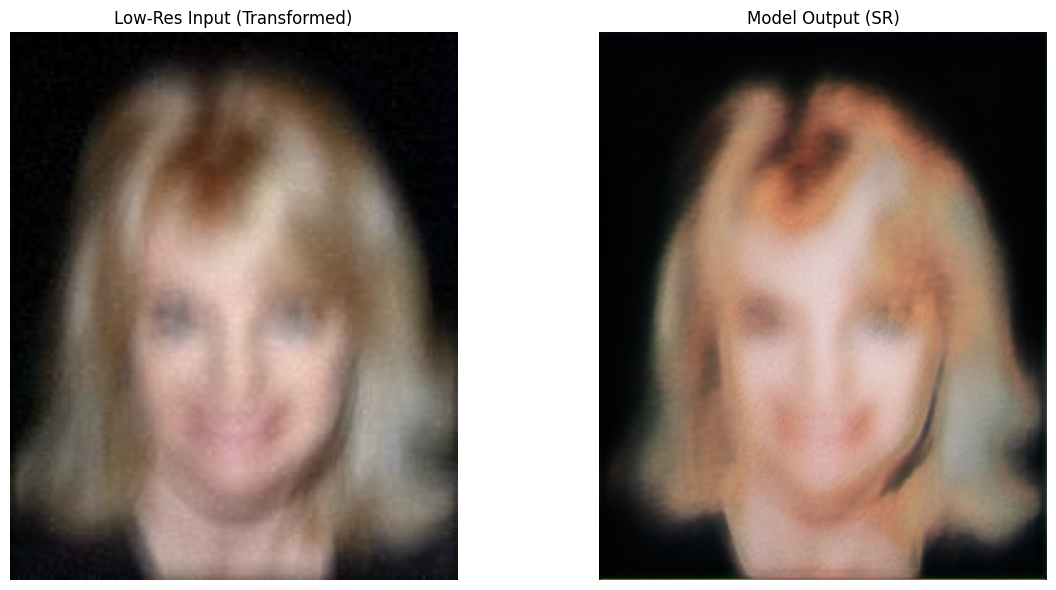

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt

# 1) Load your trained model
model = RRDBNet()
checkpoint = torch.load("/content/finetuned_realesrgan_epoch_5.pth", map_location="cpu")
model.load_state_dict(checkpoint['generator'])
#model.eval().cuda()
model.eval()
# 2) Prepare transform
transform = Compose([
    #Resize((128, 128)),
    ToTensor(),
    Normalize((0.5,) * 3, (0.5,) * 3)
])

# 3) Load original image
img = Image.open("/content/48.jpg").convert("RGB")
lr_image = transform(img)  # shape [3, 32, 32]

#lr_tensor = lr_image.unsqueeze(0).cuda()  # shape [1, 3, 32, 32]
lr_tensor = lr_image.unsqueeze(0)  # shape [1, 3, 32, 32]

# 4) Inference
with torch.no_grad():
    output = model(lr_tensor)

# 5) Denormalize outputs
output = (output.clamp(-1, 1) + 1) / 2
lr_image_vis = (lr_tensor.squeeze(0).clamp(-1, 1) + 1) / 2

# 6) Convert to numpy # resize for visual consistency
lr_np = lr_image_vis.permute(1, 2, 0).cpu().numpy()
output_np = output.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 7) Plot
plt.figure(figsize=(18, 6))


# Transformed LR image
plt.subplot(1, 3, 2)
plt.imshow(lr_np)
plt.title("Low-Res Input (Transformed)")
plt.axis("off")

# Super-res output
plt.subplot(1, 3, 3)
plt.imshow(output_np)
plt.title("Model Output (SR)")
plt.axis("off")

plt.tight_layout()
plt.show()


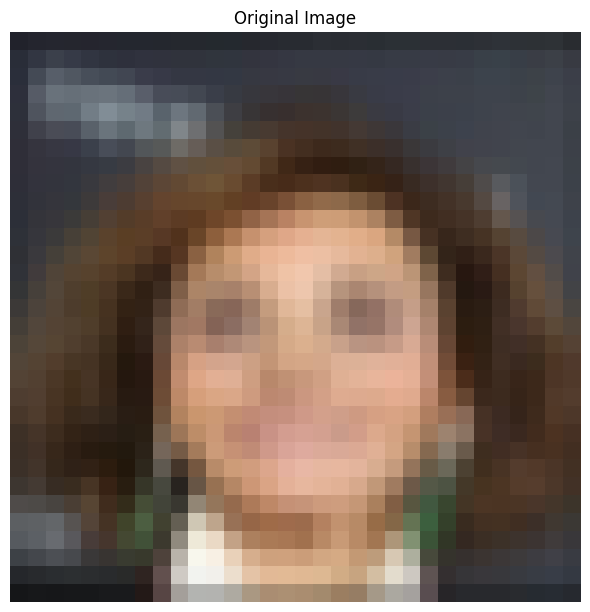

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt


# 2) Prepare transform
transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.5,) * 3, (0.5,) * 3)
])
img = Image.open("/content/2.jpg").convert("RGB")
lr_image = transform(img)  # shape [3, 32, 32]



# 5) Denormalize outputs
output = (lr_image.clamp(-1, 1) + 1) / 2

# 6) Convert to numpy

output_np = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
# 7) Plot
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(output_np)
plt.title("Original Image")
plt.axis("off")

plt.tight_layout()
plt.show()
